In [70]:
import numpy as np
import pandas as pd
from functions.sstd import *
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

# Data

We will use BMW daily price data.

In [17]:
bmw = yf.download('BMWYY')
df = bmw['Adj Close']
df.head()
ret = df.pct_change().dropna()
ret.head()

[*********************100%%**********************]  1 of 1 completed


Date
2009-12-30   -0.011060
2009-12-31   -0.000658
2010-01-04    0.010533
2010-01-05    0.016287
2010-01-06    0.016026
Name: Adj Close, dtype: float64

In [105]:
init_param = [np.mean(ret), np.std(ret), 0, 1, 10]

result = minimize(neg_likelihood_function, init_param, args=(ret,), 
                    bounds=((None, None), (None, None), (-1+1e-5, 1-1e-5), (1e-5, None), (1e-5, None)),
                    method = 'L-BFGS-B')

print(result)
print(result.x)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -9276.454274734047
        x: [ 6.317e-04  1.951e-02  1.032e-02  1.252e+00  1.000e+01]
      nit: 17
      jac: [ 5.854e+00 -1.047e+00  2.445e+00 -1.271e-01  5.874e-01]
     nfev: 144
     njev: 24
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
[6.31708134e-04 1.95108099e-02 1.03160424e-02 1.25158985e+00
 1.00030188e+01]


/Users/tonghuang/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


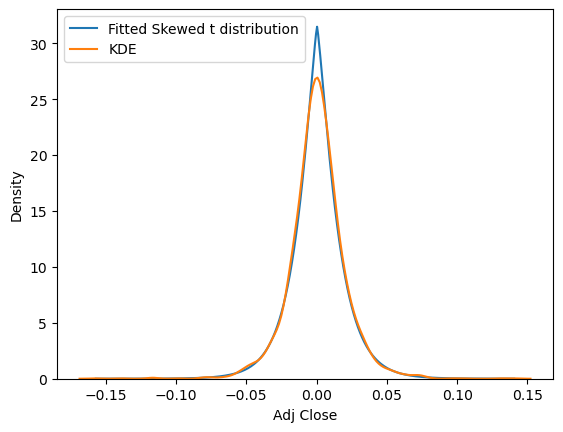

In [104]:
mu, sigma, lam, p, q = result.x

x_values = np.linspace(ret.min(), ret.max(), 400)
p_values = pdf(x_values, mu, sigma, lam, p, q)

plt.plot(x_values, p_values, label = 'Fitted Skewed t distribution')
sns.kdeplot(ret, label = 'KDE')
plt.legend()
plt.show()

# Bootstrap

In [125]:
# Function to calculate the quantile Kurt
def quKurt(y, p1=0.025, p2=0.25):
    Q = np.quantile(y, [p1, p2, 1 - p2, 1 - p1])
    k = (Q[3] - Q[0]) / (Q[2] - Q[1])
    return k

# Write a function to generate skewed t

def simulate_skewed_t(n, mu, sigma, lam, nu):
    U = np.random.uniform(0, 1, n)
    T = t.ppf(U, df=nu)
    skewed_T = mu + sigma * (lam + (1 - lam) * T) / (1 - lam * np.sign(T))
    return skewed_T

In [129]:
nboot = 5000
ModelFree_kurt = np.zeros(nboot)

for i in range(nboot):
    sample_modelFree = ret.sample(len(ret), replace=True)
    ModelFree_kurt[i] = quKurt(sample_modelFree)
    

/Users/tonghuang/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

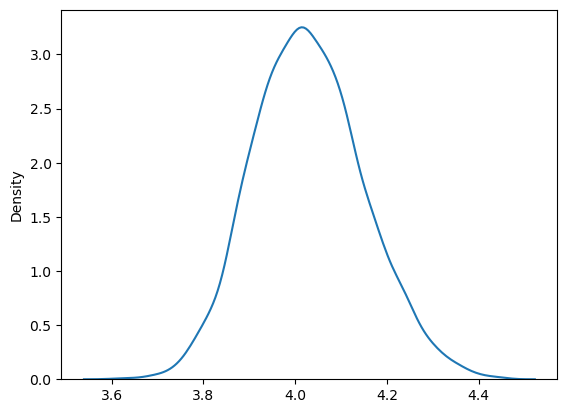

In [130]:
sns.kdeplot(ModelFree_kurt)

In [131]:
def bootstrap_ci(bootstrapped_samples, confidence_level=90):
    # Calculate the lower and upper percentile bounds
    lower_percentile = (100 - confidence_level) / 2
    upper_percentile = 100 - lower_percentile
    
    # Calculate the confidence interval
    ci_lower = np.percentile(bootstrapped_samples, lower_percentile)
    ci_upper = np.percentile(bootstrapped_samples, upper_percentile)
    
    return ci_lower, ci_upper


In [135]:
model_free_ci = bootstrap_ci(ModelFree_kurt, 90)
print("90% Model-Free Bootstrap CI for quKurt:", model_free_ci)

90% Model-Free Bootstrap CI for quKurt: (3.8428089933780374, 4.237393699106268)


#  Simulation Study: Bootstrapping the Kurtosis

In [141]:
import time
from sklearn.utils import resample
import scipy.stats as stats

In [152]:
def kurtosis(x):
    return np.mean(((x - np.mean(x)) / np.std(x))**4)

np.random.seed(3751)
niter = 400
nboot = 500
n = 50
nu = 10
trueKurtosis = 3 + 6 / (nu - 4)

correct = np.zeros((niter, 3))
width = np.zeros((niter, 3))
error = np.zeros(niter)

t1 = time.time()

for i in range(niter):
    y = stats.t.rvs(df=nu, size=n)
    boot_samples = [kurtosis(resample(y)) for _ in range(nboot)]
    
    # Method 1: Percentile method using np.percentile directly
    ci_percentile = np.percentile(boot_samples, [2.5, 97.5])
    width[i, 0] = ci_percentile[1] - ci_percentile[0]
    correct[i, 0] = (ci_percentile[0] < trueKurtosis < ci_percentile[1])
    
    # Method 2: Normal approximation
    se = np.std(boot_samples)
    ci_normal = kurtosis(y) + np.array([-1, 1]) * 1.96 * se
    width[i, 1] = ci_normal[1] - ci_normal[0]
    correct[i, 1] = (ci_normal[0] < trueKurtosis < ci_normal[1])
    
    # Method 4: Reverse percentile CI
    ci_reverse = 2 * kurtosis(y) - np.percentile(boot_samples, [97.5, 2.5])
    width[i, 2] = ci_reverse[1] - ci_reverse[0]
    correct[i, 2] = (ci_reverse[0] < trueKurtosis < ci_reverse[1])
    
    error[i] = np.mean(boot_samples) - kurtosis(y)

In [153]:
t2 = time.time()
execution_time = (t2 - t1) / 60
width_means = np.mean(width, axis=0)
correct_means = np.mean(correct, axis=0)
mean_error = np.mean(error)
mean_squared_error = np.mean(error**2)

print(f"Execution Time: {execution_time} minutes")
print(f"Mean Widths: {width_means}")
print(f"Coverage Probabilities: {correct_means}")
print(f"Mean Error: {mean_error}")
print(f"Mean Squared Error: {mean_squared_error}")

Execution Time: 0.5881422321001689 minutes
Mean Widths: [2.66679056 2.77699285 2.66679056]
Coverage Probabilities: [0.655 0.63  0.58 ]
Mean Error: -0.17744861750171573
Mean Squared Error: 0.1398672192562819


There are three kinds of bootstrap intervals are used.

* Percentile method using np.percentile directly
* Normal approximation
* Reverse percentile CI

Based on the result, the percentile method is the best, which has smallest mean widths and larger coverage probabilities.